In [1]:
import seaborn as sns
import matplotlib 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

import math
from sys import path
path.append('..//modules')
path.append('..//dumps//reg_dmo_pdf')
import time
import pandas as pd
import psycopg2 as pg
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, MetaData, Table
import pandas.io.sql as psql

#create a postgres engine and a pg connection
from modules.db_connector import *
print("DB connecting engine imported")


#print(matplotlib.rcParams.keys())

font = {'family' : 'Roboto', 
        'weight': '300',
        'size'   : 30}


axesfoo = {'labelweight': '300'}
#unified_colors
clr_mean = "red"
clr_mode = "black"
clr_median = "orange"

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axesfoo)

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    


DB connecting engine imported


In [2]:
with engine.connect() as con1:
    q = """
  select *, to_date(visit_month || '-' ||visit_year, 'Mon-Year') dd,
    case 
        when visit_month in ('Dec', 'Jan', 'Feb') THEN 'Winter'
        when visit_month in ('Mar', 'Apr', 'May') THEN 'Spring'
        when visit_month in ('Jun', 'Jul', 'Aug') THEN 'Summer'
        when visit_month in ('Sep', 'Oct', 'Nov') THEN 'Fall'
        else null end season,
    case 
        when visit_month in ('Jan', 'Feb', 'Mar') THEN 1
        when visit_month in ('Apr', 'May', 'Jun') THEN 2
        when visit_month in ('Jul', 'Aug', 'Sep') THEN 3
        when visit_month in ('Oct', 'Nov', 'Dec') THEN 4
        else null end qrt
        from gtlab.sk_ta_geosites_reviews 
        
        
left join
(select id poi_id, poi_name, CASE WHEN dmo_id is null then 'NO DMO'::text else 'DMO ' || dmo_id end nm_dmoid from gtlab.sk_pois_activities_tripadvisor_0723_details) dmos
using (poi_id)
left join
(select id poi_id, trp_3_subclass, trp_4_groups from gtlab.sk_ta_trp_cat_test) trps
using (poi_id)
where visit_month <> 'n/a'
order by dd
    """
    

   
    df_revs = pd.read_sql(q, con=con1)

    con1.close()

In [3]:
n_wo_m = df_revs.query('visit_month == "n/a"')['review_en'].count()
n_w_m = df_revs.query('visit_month != "n/a"')['review_en'].count()
n_wo_y = df_revs.query('visit_year == "n/a"')['review_en'].count()
n_w_y = df_revs.query('visit_year != "n/a"')['review_en'].count()

print(n_w_m, n_wo_m)
print(n_w_y, n_wo_y)

2463 0
2463 0


In [4]:
df_caves = df_revs.query('trp_4_groups == "Caves"')
n_reviews = len(df_revs.index)
n_caves = len(df_caves['poi_id'].unique())
n_rev_caves = df_caves['poi_id'].count()
n_rev_caves/n_reviews

df_caves['Date'] = pd.to_datetime(df_revs['dd'], format='%Y-%m-%d')
df_caves['year'] = pd.DatetimeIndex(df_caves['Date']).year
df_caves['month'] = pd.DatetimeIndex(df_caves['Date']).month



dfg1 = pd.pivot_table(df_caves, index=['Date', 'year', 'month'], values=['sent1_review_polarity', 'sent2_review_compound'], aggfunc='count')
dfg1 = dfg1.reset_index()
dfg1 =dfg1.sort_values(by=['Date'])


dfg2 = pd.pivot_table(df_caves, index=['Date', 'year', 'month'], values=['sent2_review_compound', 'sent1_review_polarity'], aggfunc='median')
dfg2 = dfg2.reset_index()
dfg2 =dfg2.sort_values(by=['Date'])




C:\Users\csb\AppData\Local\Temp\ipykernel_18392\1975569907.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caves['Date'] = pd.to_datetime(df_revs['dd'], format='%Y-%m-%d')
C:\Users\csb\AppData\Local\Temp\ipykernel_18392\1975569907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caves['year'] = pd.DatetimeIndex(df_caves['Date']).year
C:\Users\csb\AppData\Local\Temp\ipykernel_18392\1975569907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [5]:
import math
df_caves['poi_name'].unique()
#pd.pivot_table(df_caves, index='poi_name', values='poi_id', aggfunc='count')


df_annual_n = pd.pivot_table(df_caves.query('poi_id == "g274929-d1930970"'), index=[ 'year'], values='sent1_review_polarity', aggfunc='count')

dfa=pd.pivot_table(df_caves, index=[ 'visit_month'], columns='year', values='sent1_review_polarity', aggfunc='count').reset_index()

for y in range(2010, 2024):
    a = list(dfa[y])
    l = []
    for i in a:
        if math.isnan(i):
            pass
        else:
            l.append(i)
    print(y, len(l))
    



2010 1
2011 2
2012 9
2013 11
2014 11
2015 12
2016 12
2017 11
2018 12
2019 12
2020 7
2021 5
2022 6
2023 3


In [7]:
df_ssj_caves = pd.read_excel('C:\\Users\\csb\\Desktop\\notes\\ta_senti_geo_pa_dmo\\dumps\\input\ssj_caves.xlsx', sheet_name = 'Sheet1')
df_ssj_caves = df_ssj_caves.query('poi_name.notnull()')
df_ssj_caves = pd.melt(df_ssj_caves, id_vars=['poi_name','cave_name'])
df_ssj_caves = df_ssj_caves.rename(columns={'variable': 'year', 'value': 'n_real_visitors'})

df_ta_caves_ann_agg = pd.pivot_table(df_caves, index=['poi_name', 'year'], values=['sent1_review_polarity', 'sent2_review_compound'],                      
                                     aggfunc={'sent1_review_polarity': ['count', 'mean'], 
                                             'sent2_review_compound': ['count', 'mean']}
                                    )



df_ta_caves_ann_agg.columns = ['_'.join(col) for col in df_ta_caves_ann_agg.columns.values]
df_ta_caves_ann_agg = df_ta_caves_ann_agg.reset_index()
df_ta_caves_ann_std = df_caves.groupby(['poi_name', 'year'])[['sent1_review_polarity','sent2_review_compound']].std()
df_ta_caves_ann_std = df_ta_caves_ann_std.reset_index()
df_ta_caves_ann_std = df_ta_caves_ann_std.rename(columns={'sent1_review_polarity': 'sen1_std', 'sent2_review_compound': 'sent2_std'})


df_ta_caves = pd.merge(df_ta_caves_ann_agg, df_ta_caves_ann_std, on=['poi_name', 'year' ], how='left')
df_ssj_ta_caves = pd.merge(df_ta_caves, df_ssj_caves, on=['poi_name', 'year' ], how='left')
df_ssj_ta_caves = df_ssj_ta_caves.query('sent1_review_polarity_count.notnull() and sent1_review_polarity_count > 1 and n_real_visitors.notnull()')
df_ssj_ta_caves = df_ssj_ta_caves.reset_index()

df_cav_negative_s1 = pd.pivot_table(df_caves.query('sent1_review_polarity < -0.05'), index = ['poi_name', 'year'], values='sent1_review_polarity', aggfunc='count')
df_cav_negative_s1 = df_cav_negative_s1.reset_index()
df_cav_negative_s1 = df_cav_negative_s1.rename(columns={'sent1_review_polarity': 'sent1_neg_n'})


df_cav_positive_s1 = pd.pivot_table(df_caves.query('sent1_review_polarity > 0.05'), index = ['poi_name', 'year'], values='sent1_review_polarity', aggfunc='count')
df_cav_positive_s1 = df_cav_positive_s1.reset_index()
df_cav_positive_s1 = df_cav_positive_s1.rename(columns={'sent1_review_polarity': 'sent1_pos_n'})


df_cav_neutral_s1 = pd.pivot_table(df_caves.query('sent1_review_polarity <= 0.05 and sent1_review_polarity >=-0.05'), index = ['poi_name', 'year'], values='sent1_review_polarity', aggfunc='count')
df_cav_neutral_s1 = df_cav_neutral_s1.reset_index()
df_cav_neutral_s1 = df_cav_neutral_s1.rename(columns={'sent1_review_polarity': 'sent1_neu_n'})

df_sent1_posneg_s1 = pd.merge(df_cav_positive_s1, df_cav_negative_s1, on = ['poi_name','year'], how='left')
df_sent1_posnegneu_s1 = pd.merge(df_sent1_posneg_s1, df_cav_neutral_s1, on = ['poi_name','year'], how='left')

df_cav_negative_s2 = pd.pivot_table(df_caves.query('sent2_review_compound < -0.05'), index = ['poi_name', 'year'], values='sent2_review_compound', aggfunc='count')
df_cav_negative_s2 = df_cav_negative_s2.reset_index()
df_cav_negative_s2 = df_cav_negative_s2.rename(columns={'sent2_review_compound': 'sent2_neg_n'})


df_cav_positive_s2 = pd.pivot_table(df_caves.query('sent2_review_compound > 0.05'), index = ['poi_name', 'year'], values='sent2_review_compound', aggfunc='count')
df_cav_positive_s2 = df_cav_positive_s2.reset_index()
df_cav_positive_s2 = df_cav_positive_s2.rename(columns={'sent2_review_compound': 'sent2_pos_n'})


df_cav_neutral_s2 = pd.pivot_table(df_caves.query('sent2_review_compound <= 0.05 and sent2_review_compound >=-0.05'), index = ['poi_name', 'year'], values='sent2_review_compound', aggfunc='count')
df_cav_neutral_s2 = df_cav_neutral_s2.reset_index()
df_cav_neutral_s2 = df_cav_neutral_s2.rename(columns={'sent2_review_compound': 'sent2_neu_n'})

df_sent2_posneg_s2 = pd.merge(df_cav_positive_s2, df_cav_negative_s2, on = ['poi_name','year'], how='left')
df_sent2_posnegneu_s2 = pd.merge(df_sent2_posneg_s2, df_cav_neutral_s2, on = ['poi_name','year'], how='left')
df_sents_n = pd.merge(df_sent1_posnegneu_s1, df_sent2_posnegneu_s2, on =['poi_name','year'], how='left')

dfskws1 = df_caves[['poi_name','year', 'sent1_review_polarity']]
dfskws1 = dfskws1.groupby(['poi_name','year']).skew()
dfskws1 =  dfskws1.reset_index()
dfskws1 = dfskws1.rename(columns={"sent1_review_polarity": "sent1_skew"})
dfskws2 = df_caves[['poi_name','year', 'sent2_review_compound']]
dfskws2 = dfskws2.groupby(['poi_name','year']).skew()
dfskws2 =  dfskws2.reset_index()
dfskws2 = dfskws2.rename(columns={"sent2_review_compound": "sent2_skew"})

df_sent_skews = pd.merge(dfskws1, dfskws2, on = ["poi_name", "year"])


df_ssj_ta_caves = pd.merge(df_ssj_ta_caves, df_sents_n, on =['poi_name','year'], how='left')
df_ssj_ta_caves = pd.merge(df_ssj_ta_caves, df_sent_skews, on =['poi_name','year'], how='left')

In [10]:
#SAMPLE SIZE
#https://datagy.io/python-confidence-intervals/
#T distribution
#sn < 30 or gen pop std null

#Z distribution
#sn > 30 or gen pop not null

#pow(1.96,2)*0.5*((1-0.5)/(pow(0.05,2)))
#384/(1+(384/128000))

#pp proportion rate 0.5 -> conservative estimate (either answer or no answer)
pp = 0.5
# z score assuming aproximate normal distribution for CL 95 %
#ME for CL
ME = 0.05
Z = 1.96
#n = sample population -> n reviews for given year per given cave
#N = total population -> n real visitors for given year per given cave

#ASSUMING NORMAL DISTRIBUTION


for i, N in zip(df_ssj_ta_caves.index, df_ssj_ta_caves['n_real_visitors']):
    #https://www.omnicalculator.com/statistics/sample-size
    #ns sample size for 95 CL ME 5%
    ns = pow(Z,2)*pp*((1-pp)/(pow(ME,2)))
    #ns_correction for finite population
    ns_correction = ns / (1 + (ns/N))
    df_ssj_ta_caves.loc[i, 'samp_size_95CL_ME005'] = ns_correction
    
    
#https://www.omnicalculator.com/statistics/margin-of-error

#MARGINS OF ERROR
#ASSUMING NORMAL DISTRIBUTION
#https://www.omnicalculator.com/statistics/margin-of-error
from math import sqrt

Z = 1.96
#n_ -> sample size
#P - > total population
#pp -> proportion of successes 
#CL Confindence level 95
#n_ans_ n success
#p = n_ans / n

def moe_ans(N, n, ns, Z):
    pp = ns/n
    moe = Z * sqrt((pp*(1-pp))/((N-1)*(n/(N-n))))
    return moe
    

moe_ans(5000,400,260,2.05)    



for i, P, n, pos_s1, neg_s1, neu_s1, pos_s2, neg_s2, neu_s2 in zip(
df_ssj_ta_caves.index,
df_ssj_ta_caves['n_real_visitors'],
df_ssj_ta_caves['sent1_review_polarity_count'],
df_ssj_ta_caves['sent1_pos_n'],
df_ssj_ta_caves['sent1_neg_n'],
df_ssj_ta_caves['sent1_neu_n'],
df_ssj_ta_caves['sent2_pos_n'],
df_ssj_ta_caves['sent2_neg_n'],
df_ssj_ta_caves['sent2_neu_n']
):
    moe_ans_pos_s1 = moe_ans(P, n, pos_s1, Z)
    moe_ans_neg_s1 = moe_ans(P, n, neg_s1, Z)
    moe_ans_neu_s1 = moe_ans(P, n, neu_s1, Z)
    moe_ans_pos_s2 = moe_ans(P, n, pos_s2, Z)
    moe_ans_neg_s2 = moe_ans(P, n, neg_s2, Z)
    moe_ans_neu_s2 = moe_ans(P, n, neu_s2, Z)
    df_ssj_ta_caves.loc[i, 'moe_ans_pos_s1'] = moe_ans_pos_s1
    df_ssj_ta_caves.loc[i, 'moe_ans_neg_s1'] = moe_ans_neg_s1
    df_ssj_ta_caves.loc[i, 'moe_ans_neu_s1'] = moe_ans_neu_s1
    df_ssj_ta_caves.loc[i, 'moe_ans_pos_s2'] = moe_ans_pos_s2
    df_ssj_ta_caves.loc[i, 'moe_ans_neg_s2'] = moe_ans_neg_s2
    df_ssj_ta_caves.loc[i, 'moe_ans_neu_s2'] = moe_ans_neu_s2

    
    





C:\Users\csb\AppData\Local\Temp\ipykernel_18392\1572293028.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['pct1_sent1_pos'] = (d['sent1_pos_n']/d['sent1_review_polarity_count'])*100
C:\Users\csb\AppData\Local\Temp\ipykernel_18392\1572293028.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['pct1_sent1_neu'] = (d['sent1_neu_n']/d['sent1_review_polarity_count'])*100
C:\Users\csb\AppData\Local\Temp\ipykernel_18392\1572293028.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

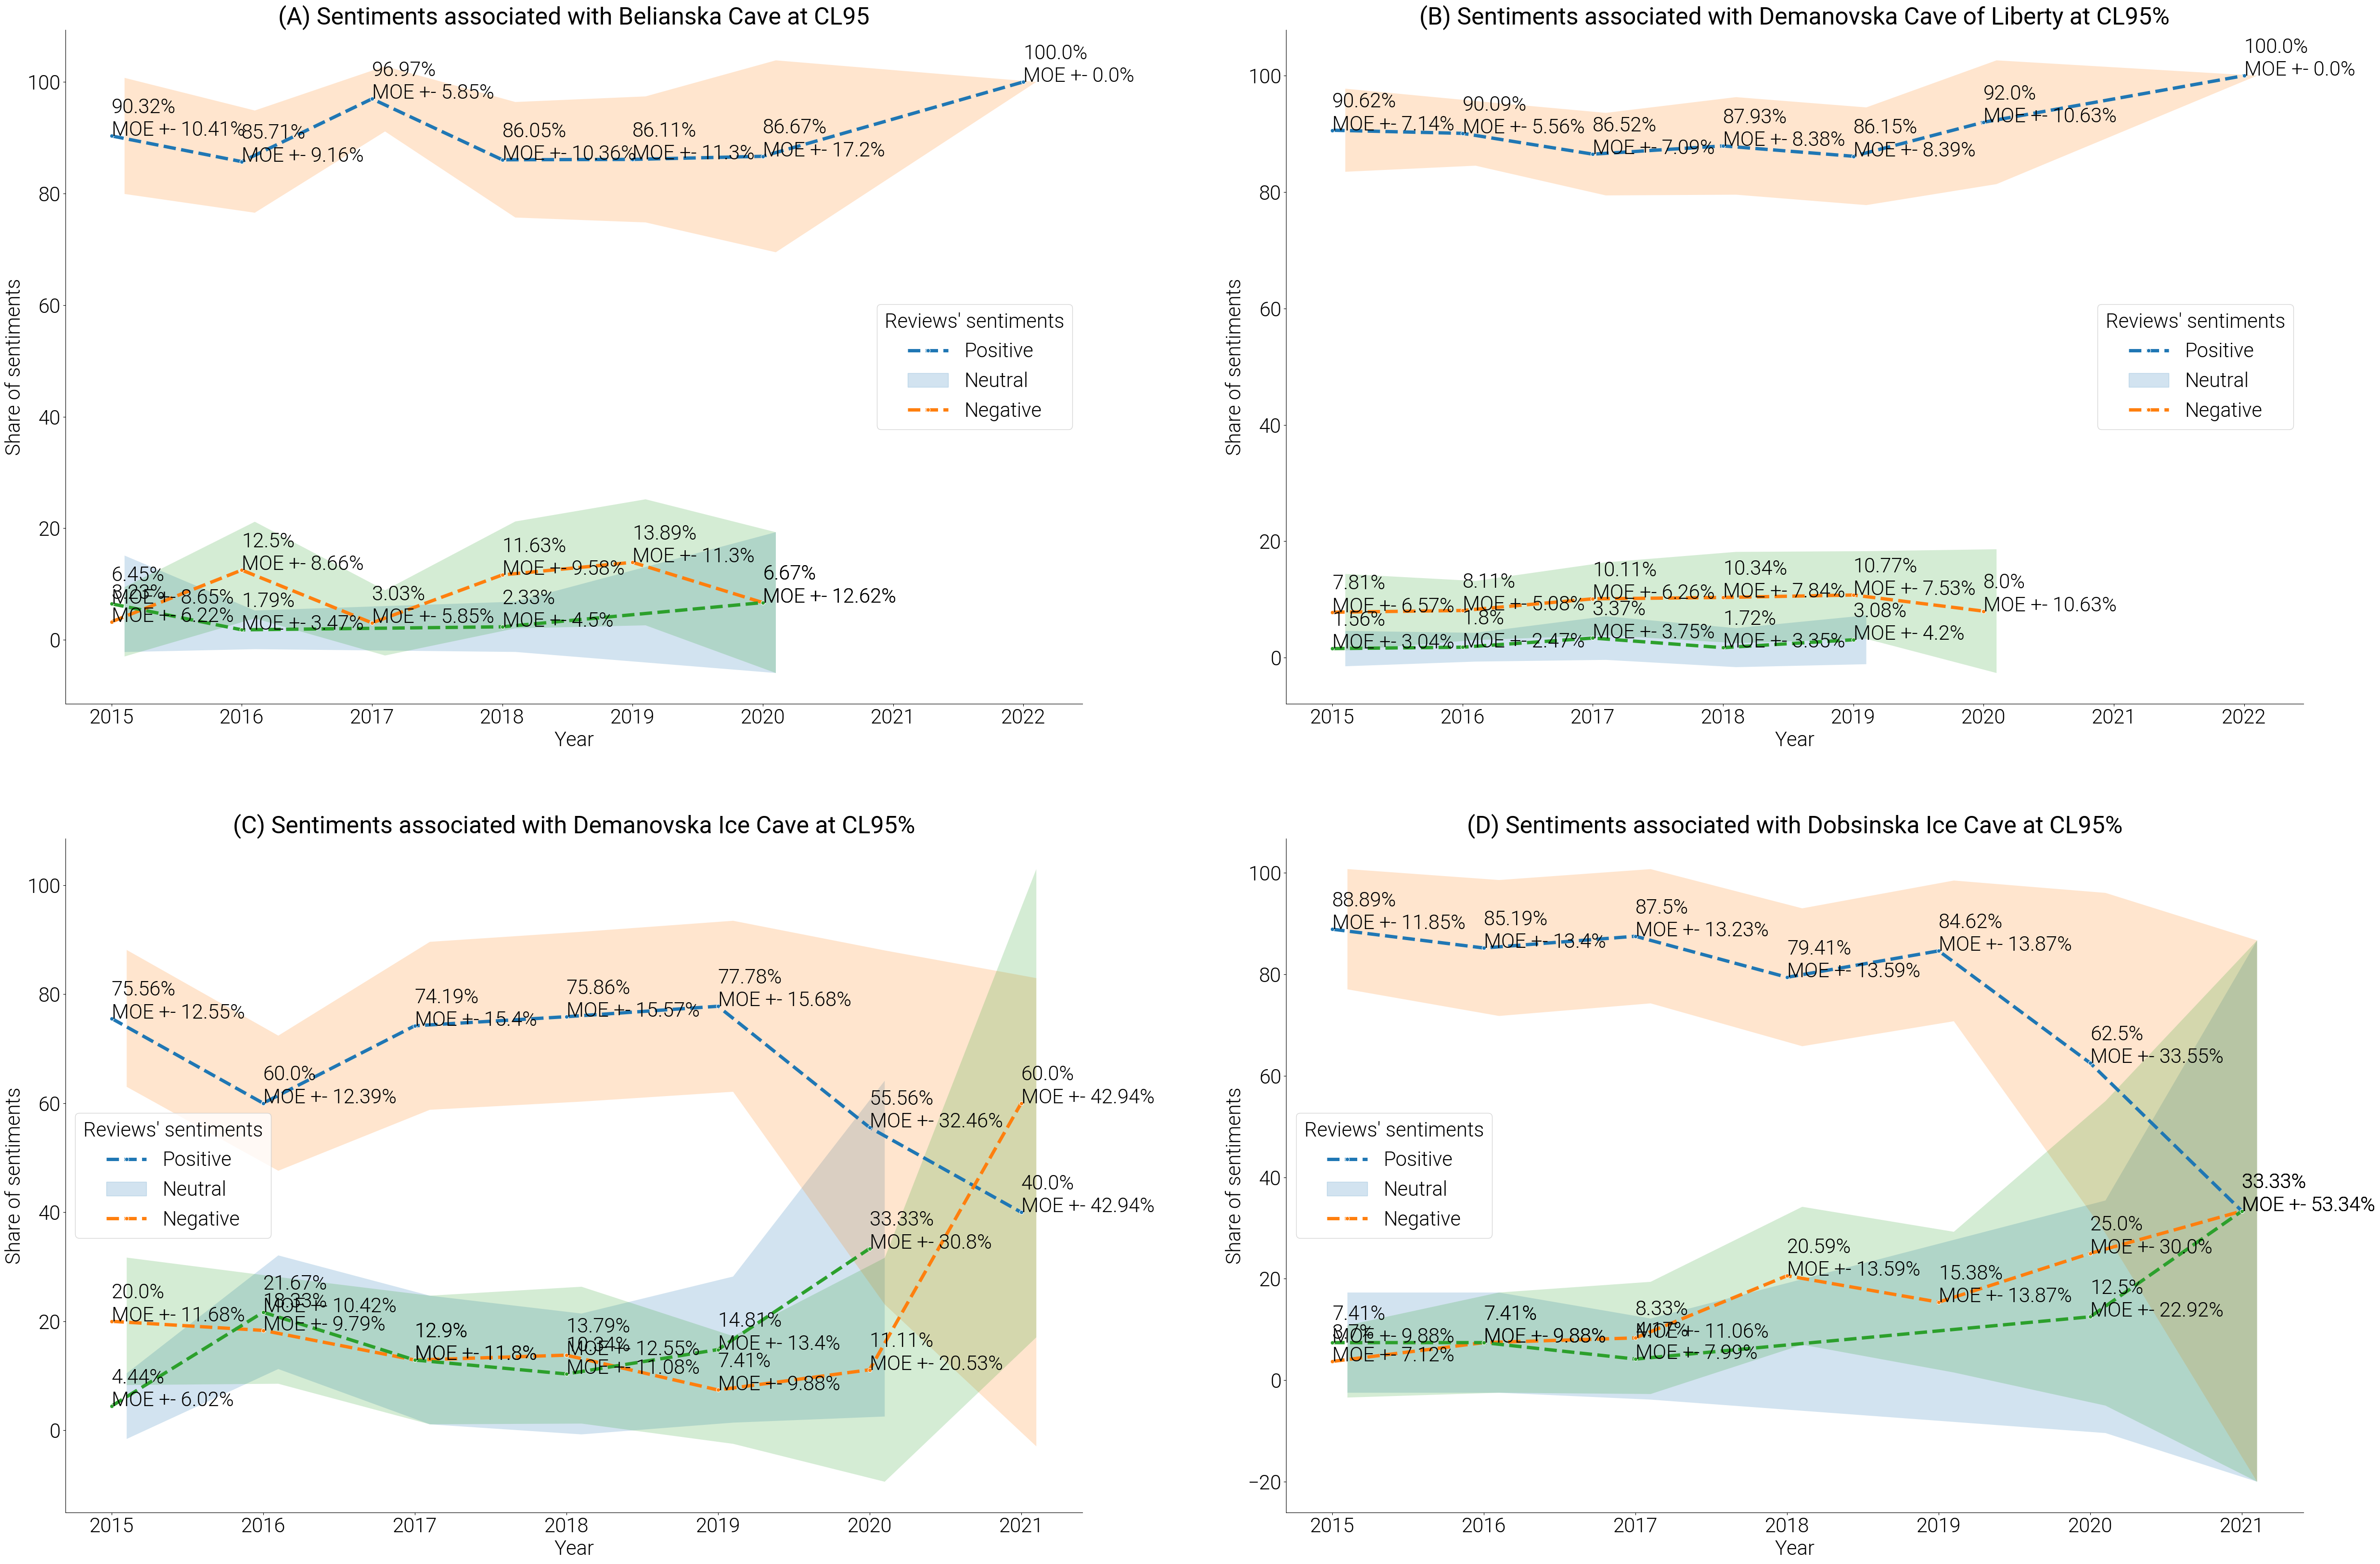

In [12]:
#VADER SENTIMENTS
l_dfx = []
caves_u_nms = list(df_ssj_ta_caves['poi_name'].unique())

for poi in caves_u_nms:
    if poi == "Brestovská Cave":
        pass
    else:
        d = df_ssj_ta_caves.query('poi_name =="' + poi + '"')
        d['pct1_sent1_pos'] = (d['sent1_pos_n']/d['sent1_review_polarity_count'])*100
        d['pct1_sent1_neu'] = (d['sent1_neu_n']/d['sent1_review_polarity_count'])*100
        d['pct1_sent1_neg'] = (d['sent1_neg_n']/d['sent1_review_polarity_count'])*100
        d = d[['poi_name', 'year', 'pct1_sent1_pos', 'pct1_sent1_neu', 'pct1_sent1_neg', 'moe_ans_pos_s1', 'moe_ans_neu_s1', 'moe_ans_neg_s1']]
        dfx = d.set_index(['poi_name', 'year', 'moe_ans_pos_s1', 'moe_ans_neu_s1', 'moe_ans_neg_s1']).stack().reset_index()
    #dfx = dfx.set_index(['poi_name', 'year', 'level_5', 0]).stack().reset_index()
        dfx = dfx.rename(columns={'level_5': 'sent_type', 0: 'sent_pct_share'})
        for i, moe_ans_pos_s1, moe_ans_neu_s1, moe_ans_neg_s1, sent_type in zip(dfx.index, dfx['moe_ans_pos_s1'], dfx['moe_ans_neu_s1'], dfx['moe_ans_neg_s1'], dfx['sent_type']):
            if sent_type == 'pct1_sent1_pos':
                dfx.loc[i, 'moe'] = moe_ans_pos_s1
                dfx.loc[i, 'clr'] = "#5AB2FF"
            elif sent_type == 'pct1_sent1_neu':
                dfx.loc[i, 'moe'] = moe_ans_neu_s1
                dfx.loc[i, 'clr'] = "#A0DEFF"
            elif sent_type == 'pct1_sent1_neg':
                dfx.loc[i, 'moe'] = moe_ans_neg_s1
                dfx.loc[i, 'clr'] = "#CAF4FF"

        l_dfx.append(dfx)
        
import math
fig = plt.figure(figsize=(60, 40))
gs = GridSpec(2, 2, figure=fig)
nl = '\n'

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])



#AX1#AX1#AX1#AX1#AX1#AX1
g1 = sns.lineplot(data=l_dfx[0], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax1)
sns.despine()
g1_dfx_neg = l_dfx[0].query('sent_type == "pct1_sent1_neg"')
g1_dfx_pos = l_dfx[0].query('sent_type == "pct1_sent1_pos"')
g1_dfx_neu = l_dfx[0].query('sent_type == "pct1_sent1_neu"')

ax1.fill_between(g1_dfx_neg['year']+0.1, g1_dfx_neg['sent_pct_share'] - g1_dfx_neg['moe']*100, g1_dfx_neg['sent_pct_share'] + g1_dfx_neg['moe']*100, alpha=0.2)
ax1.fill_between(g1_dfx_pos['year']+0.1, g1_dfx_pos['sent_pct_share'] - g1_dfx_pos['moe']*100, g1_dfx_pos['sent_pct_share'] + g1_dfx_pos['moe']*100, alpha=0.2)
ax1.fill_between(g1_dfx_neu['year']+0.1, g1_dfx_neu['sent_pct_share'] - g1_dfx_neu['moe']*100, g1_dfx_neu['sent_pct_share'] + g1_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[0]['year'], l_dfx[0]['sent_pct_share'], l_dfx[0]['moe']):
    ax1.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')
    
ax1.set(xlabel='Year', ylabel='Share of sentiments')
ax1.set(title="\n".join(textwrap.wrap("(A) Sentiments associated with " + list(l_dfx[0]['poi_name'])[0]+ " at CL95"  ,100)))
ax1.legend(title='Reviews\' sentiments', loc='center right', labels=['Positive', 'Neutral', 'Negative'])

#AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2
g2 = sns.lineplot(data=l_dfx[1], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax2)
sns.despine()
g2_dfx_neg = l_dfx[1].query('sent_type == "pct1_sent1_neg"')
g2_dfx_pos = l_dfx[1].query('sent_type == "pct1_sent1_pos"')
g2_dfx_neu = l_dfx[1].query('sent_type == "pct1_sent1_neu"')

ax2.fill_between(g2_dfx_neg['year']+0.1, g2_dfx_neg['sent_pct_share'] - g2_dfx_neg['moe']*100, g2_dfx_neg['sent_pct_share'] + g2_dfx_neg['moe']*100, alpha=0.2)
ax2.fill_between(g2_dfx_pos['year']+0.1, g2_dfx_pos['sent_pct_share'] - g2_dfx_pos['moe']*100, g2_dfx_pos['sent_pct_share'] + g2_dfx_pos['moe']*100, alpha=0.2)
ax2.fill_between(g2_dfx_neu['year']+0.1, g2_dfx_neu['sent_pct_share'] - g2_dfx_neu['moe']*100, g2_dfx_neu['sent_pct_share'] + g2_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[1]['year'], l_dfx[1]['sent_pct_share'], l_dfx[1]['moe']):
    ax2.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')

ax2.set(xlabel='Year', ylabel='Share of sentiments')
ax2.set(title="\n".join(textwrap.wrap("(B) Sentiments associated with " + list(l_dfx[1]['poi_name'])[0]+ " at CL95%"  ,100)))
ax2.legend(title='Reviews\' sentiments', loc='center right', labels=['Positive', 'Neutral', 'Negative'])

#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3
g3 = sns.lineplot(data=l_dfx[2], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax3)
sns.despine()
g3_dfx_neg = l_dfx[2].query('sent_type == "pct1_sent1_neg"')
g3_dfx_pos = l_dfx[2].query('sent_type == "pct1_sent1_pos"')
g3_dfx_neu = l_dfx[2].query('sent_type == "pct1_sent1_neu"')

ax3.fill_between(g3_dfx_neg['year']+0.1, g3_dfx_neg['sent_pct_share'] - g3_dfx_neg['moe']*100, g3_dfx_neg['sent_pct_share'] + g3_dfx_neg['moe']*100, alpha=0.2)
ax3.fill_between(g3_dfx_pos['year']+0.1, g3_dfx_pos['sent_pct_share'] - g3_dfx_pos['moe']*100, g3_dfx_pos['sent_pct_share'] + g3_dfx_pos['moe']*100, alpha=0.2)
ax3.fill_between(g3_dfx_neu['year']+0.1, g3_dfx_neu['sent_pct_share'] - g3_dfx_neu['moe']*100, g3_dfx_neu['sent_pct_share'] + g3_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[2]['year'], l_dfx[2]['sent_pct_share'], l_dfx[2]['moe']):
    ax3.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')

ax3.set(xlabel='Year', ylabel='Share of sentiments')
ax3.set(title="\n".join(textwrap.wrap("(C) Sentiments associated with " + list(l_dfx[2]['poi_name'])[0]+ " at CL95%"  ,100)))
ax3.legend(title='Reviews\' sentiments', loc='center left', labels=['Positive', 'Neutral', 'Negative'])

#AX4#AX4#AX4#AX4#AX4#AX4#AX4#AX4#AX4
g4 = sns.lineplot(data=l_dfx[3], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax4)
sns.despine()
g4_dfx_neg = l_dfx[3].query('sent_type == "pct1_sent1_neg"')
g4_dfx_pos = l_dfx[3].query('sent_type == "pct1_sent1_pos"')
g4_dfx_neu = l_dfx[3].query('sent_type == "pct1_sent1_neu"')

ax4.fill_between(g4_dfx_neg['year']+0.1, g4_dfx_neg['sent_pct_share'] - g4_dfx_neg['moe']*100, g4_dfx_neg['sent_pct_share'] + g4_dfx_neg['moe']*100, alpha=0.2)
ax4.fill_between(g4_dfx_pos['year']+0.1, g4_dfx_pos['sent_pct_share'] - g4_dfx_pos['moe']*100, g4_dfx_pos['sent_pct_share'] + g4_dfx_pos['moe']*100, alpha=0.2)
ax4.fill_between(g4_dfx_neu['year']+0.1, g4_dfx_neu['sent_pct_share'] - g4_dfx_neu['moe']*100, g4_dfx_neu['sent_pct_share'] + g4_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[3]['year'], l_dfx[3]['sent_pct_share'], l_dfx[3]['moe']):
    ax4.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')

ax4.set(xlabel='Year', ylabel='Share of sentiments')
ax4.set(title="\n".join(textwrap.wrap("(D) Sentiments associated with " + list(l_dfx[3]['poi_name'])[0]+ " at CL95%"  ,100)))
ax4.legend(title='Reviews\' sentiments', loc='center left', labels=['Positive', 'Neutral', 'Negative'])

plt.savefig("dumps/exported_figs/vaderCL95_caves.svg", bbox_inches="tight")


In [ ]:
#NOT USED
#ax1.errorbar(dfx_neg['year'], dfx_neg['sent_pct_share'], dfx_neg['moe'], color='tab:blue', ecolor='tab:blue')
#ax1.errorbar(dfx_pos['year'], dfx_pos['sent_pct_share'], dfx_pos['moe'], color='tab:red', ecolor='tab:red')
#ax1.errorbar(dfx_neu['year'], dfx_neu['sent_pct_share'], dfx_neu['moe'], color='tab:green', ecolor='tab:green')
#ax1.legend(loc="upper right")


# plot
#ax1 = sns.histplot(data=dfx, y='year', hue='sent_type', weights='sent_pct_share', discrete=True, multiple='stack', shrink=0.8)



"""
# iterate through each container
for c in ax1.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [round(v.get_width(),2) if v.get_width() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax1.bar_label(c, labels=labels, fmt='%.2f%%', label_type='center')
    
#ax1.set_xlim(0.0,1.5)

import inspect


for i, y, sent_type, pct_sent, moe, in zip(dfx.index, dfx['year'], dfx['sent_type'],  dfx['sent_pct_share'], dfx['moe']):
    if sent_type == 'pct1_sent1_neg':
        ax1.axhline(y, pct_sent - moe, pct_sent+moe)
    elif sent_type == 'pct1_sent1_neu':
        former_sent = list(dfx.query('year == '+ str(y) +'  and sent_type == "pct1_sent1_neg"')['sent_pct_share'])
        former_sent = list(former_sent)
        if len(former_sent) == 0:
            pass
        else:
            print(former_sent)
            ax1.axhline(y-0.1, former_sent[0] + pct_sent - moe, former_sent[0] + pct_sent+moe)
    elif sent_type == 'pct1_sent1_pos':
        former_sent = list(dfx.query('year == '+ str(y) +'  and sent_type in ["pct1_sent1_neu", "pct1_sent1_neg"]')['sent_pct_share'])
        former_sent = list(former_sent)
        if len(former_sent) == 0:
            pass
        else:
            
            #print(former_sent)
            f_sent = sum(former_sent)
            #print(y, f_sent, pct_sent)
            hline_start = (f_sent+pct_sent) - moe
            hline_end = (f_sent +pct_sent) + moe
            print(y, hline_start, hline_end, moe)
            ax1.axhline(y+0.1, hline_start, hline_end, label="foo", in_layout=True)


                
            
            
            #print(rect_end, rect_width)
            #if rect_end == y and round(rect_width,6) == round(pct_sent,6):
                #print("MATCH", rect_end, rect_width, y, pct_sent, moe)

                
                for i, y, pct_sent, moe in zip(dfx.index, dfx['year'], dfx['sent_pct_share'], dfx['moe']):
    #print(y, pct_sent)
    for c in ax1.get_children():
        if type(c) == matplotlib.patches.Rectangle:
            #print(c)
            rect_x =  math.ceil(c.xy[0])
            rect_y = math.ceil(c.xy[1])
            rect_width = c.get_width()
            if rect_x == 0 and rect_y == y and rect_width == pct_sent:
                print(rect_x, rect_y, rect_width, pct_sent,moe)
                print(c)
                ax1.axhline(rect_y, rect_width - (moe), rect_width+(moe))
            elif rect_x == pct_sent and rect_y == y and rect_width == pct_sent:
                print(rect_x, rect_y, rect_width, pct_sent,moe)
                print(c)
                ax1.axhline(rect_y, rect_width - (moe), rect_width+(moe))
            elif rect_x == 1 and rect_y == y and rect_width == pct_sent:
                print(rect_x, rect_y, rect_width, pct_sent,moe)
                print(c)
                ax1.axhline(rect_y, rect_width - (moe), rect_width+(moe))
"""



In [21]:
#textblob SENTIMENTS
l_dfx = []
caves_u_nms = list(df_ssj_ta_caves['poi_name'].unique())

for poi in caves_u_nms:
    if poi == "Brestovská Cave":
        pass
    else:
        d = df_ssj_ta_caves.query('poi_name =="' + poi + '"')
        d['pct2_sent2_pos'] = (d['sent2_pos_n']/d['sent1_review_polarity_count'])*100
        d['pct2_sent2_neu'] = (d['sent2_neu_n']/d['sent1_review_polarity_count'])*100
        d['pct2_sent2_neg'] = (d['sent2_neg_n']/d['sent1_review_polarity_count'])*100
        d = d[['poi_name', 'year', 'pct2_sent2_pos', 'pct2_sent2_neu', 'pct2_sent2_neg', 'moe_ans_pos_s2', 'moe_ans_neu_s2', 'moe_ans_neg_s2']]
        dfx = d.set_index(['poi_name', 'year', 'moe_ans_pos_s2', 'moe_ans_neu_s2', 'moe_ans_neg_s2']).stack().reset_index()
    #dfx = dfx.set_index(['poi_name', 'year', 'level_5', 0]).stack().reset_index()
        dfx = dfx.rename(columns={'level_5': 'sent_type', 0: 'sent_pct_share'})
        for i, moe_ans_pos_s2, moe_ans_neu_s2, moe_ans_neg_s2, sent_type in zip(dfx.index, dfx['moe_ans_pos_s2'], dfx['moe_ans_neu_s2'], dfx['moe_ans_neg_s2'], dfx['sent_type']):
            if sent_type == 'pct2_sent2_pos':
                dfx.loc[i, 'moe'] = moe_ans_pos_s2
                dfx.loc[i, 'clr'] = "#5AB2FF"
            elif sent_type == 'pct2_sent2_neu':
                dfx.loc[i, 'moe'] = moe_ans_neu_s2
                dfx.loc[i, 'clr'] = "#A0DEFF"
            elif sent_type == 'pct2_sent2_neg':
                dfx.loc[i, 'moe'] = moe_ans_neg_s2
                dfx.loc[i, 'clr'] = "#CAF4FF"

        l_dfx.append(dfx)
        


C:\Users\csb\AppData\Local\Temp\ipykernel_18392\3068511610.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['pct2_sent2_pos'] = (d['sent2_pos_n']/d['sent1_review_polarity_count'])*100
C:\Users\csb\AppData\Local\Temp\ipykernel_18392\3068511610.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['pct2_sent2_neu'] = (d['sent2_neu_n']/d['sent1_review_polarity_count'])*100
C:\Users\csb\AppData\Local\Temp\ipykernel_18392\3068511610.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

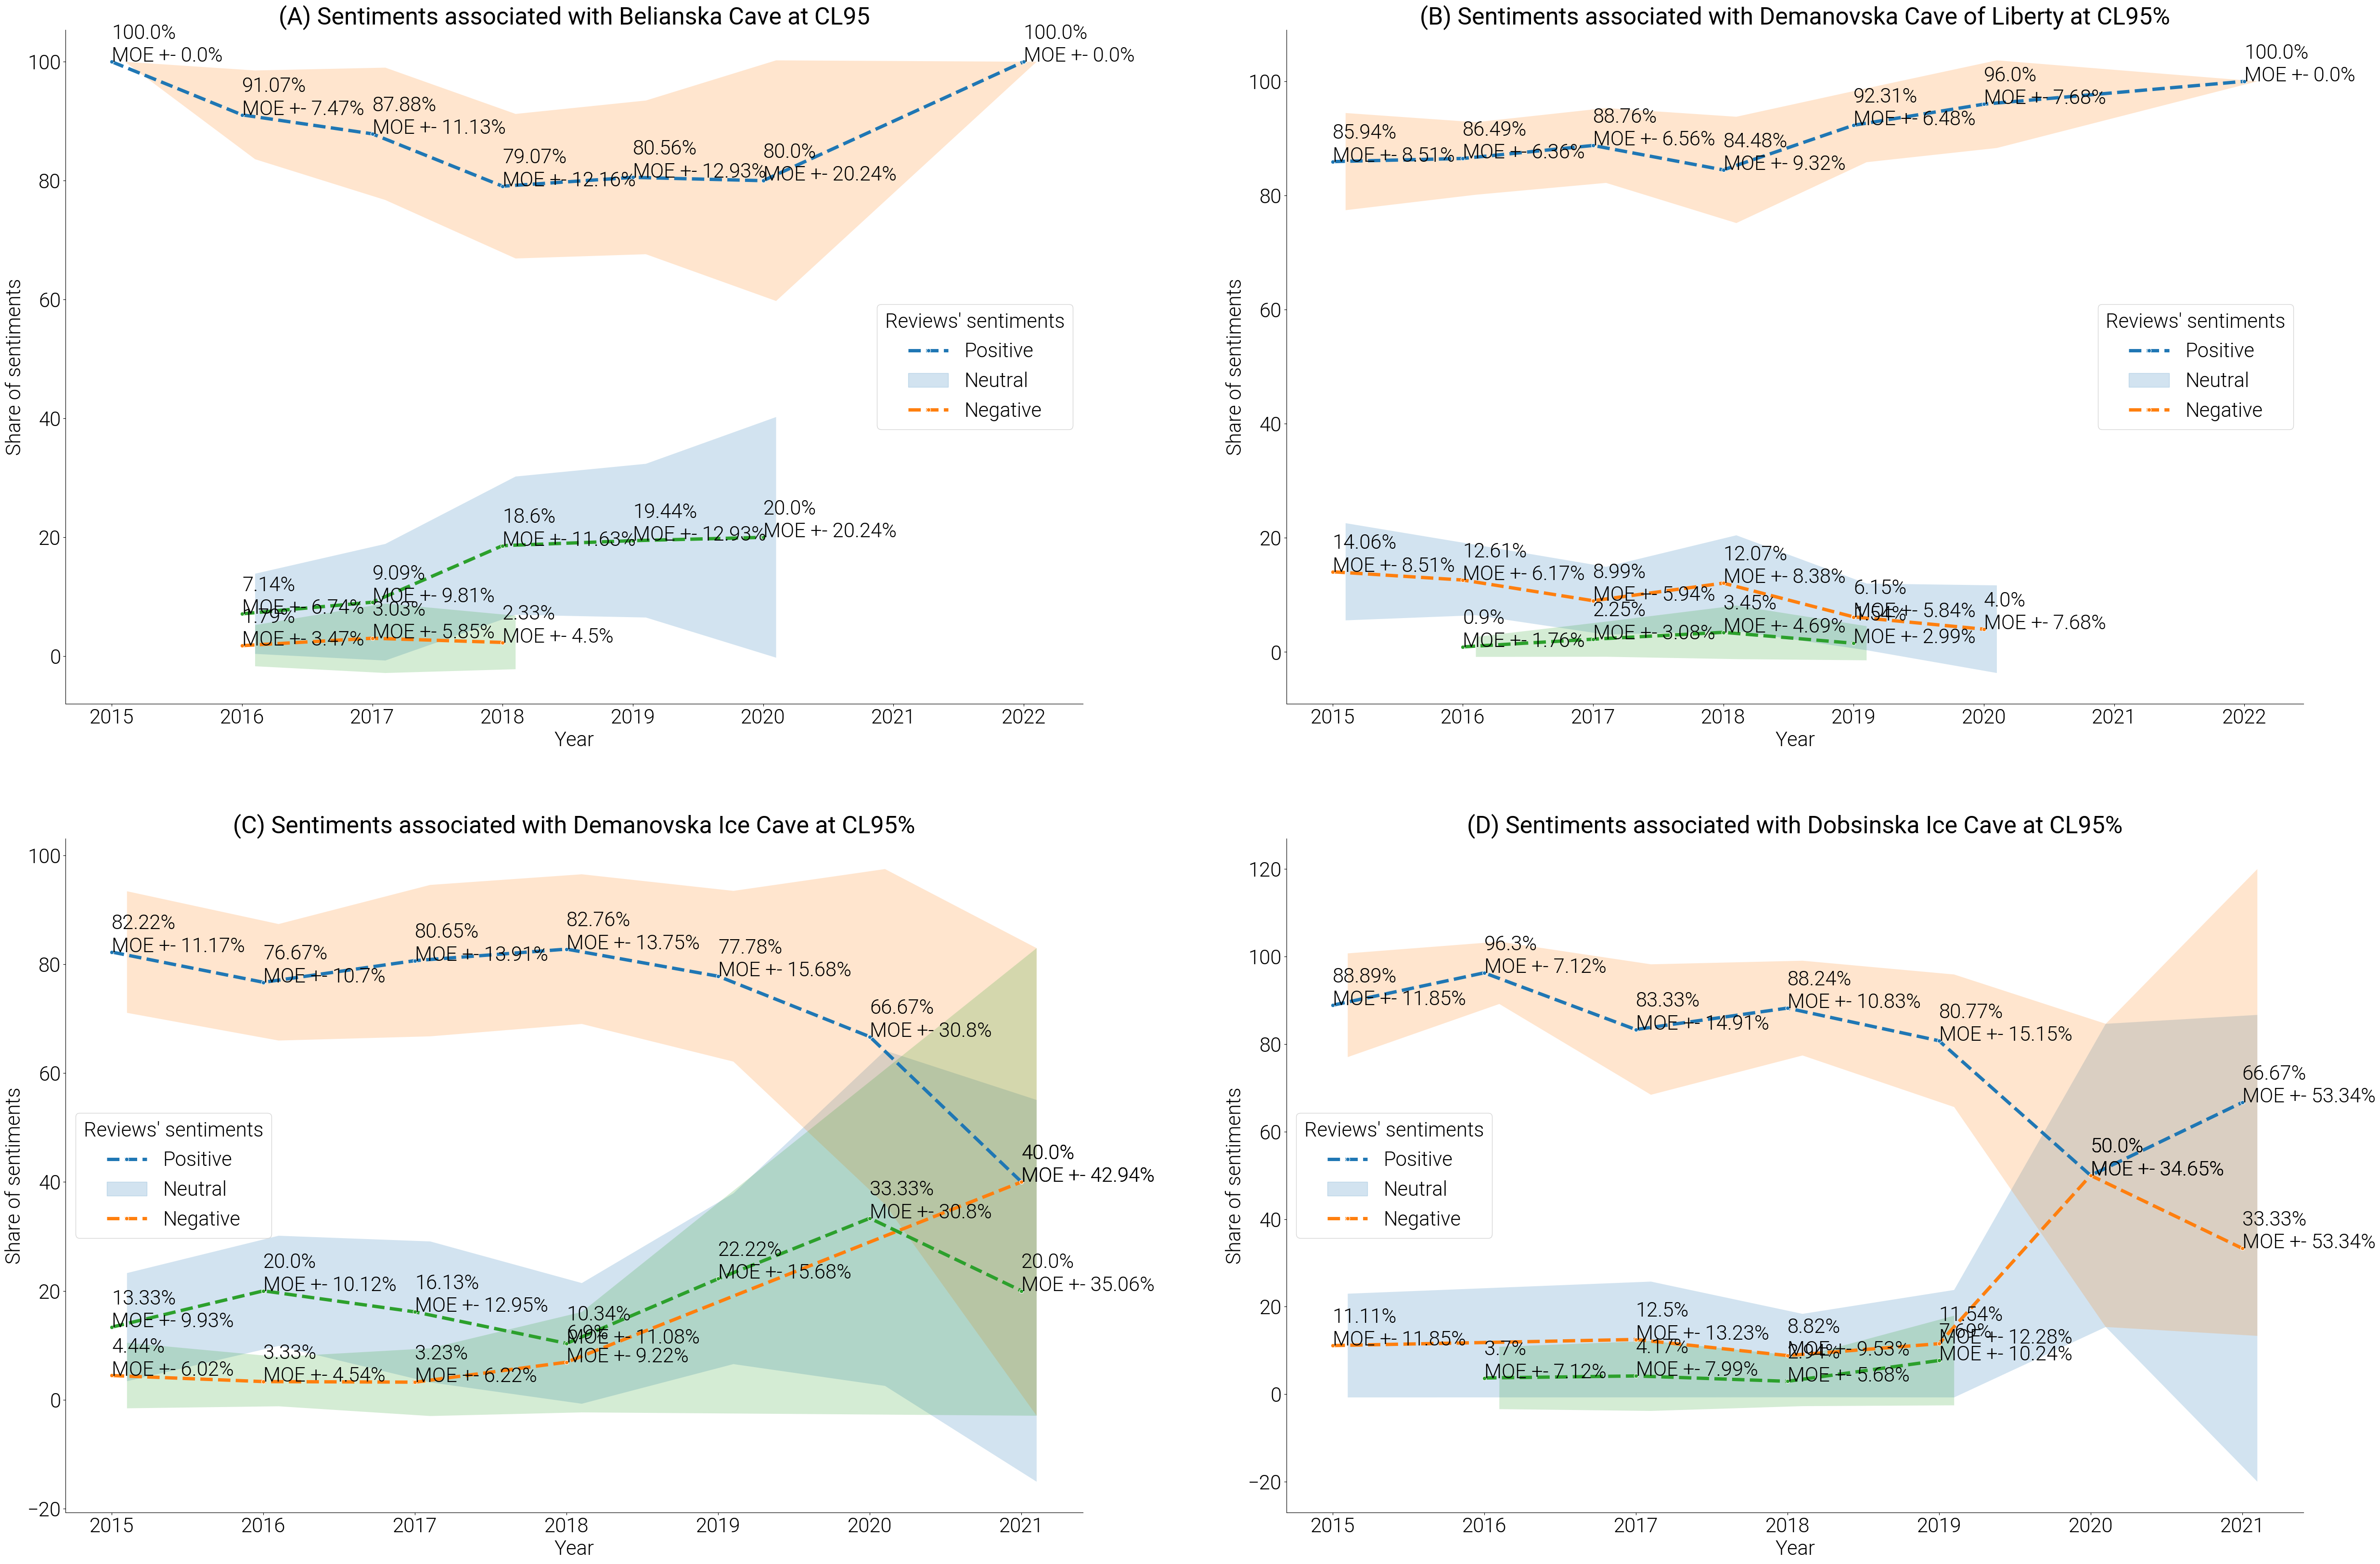

In [22]:
import math
fig = plt.figure(figsize=(60, 40))
gs = GridSpec(2, 2, figure=fig)
nl = '\n'

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])



#AX1#AX1#AX1#AX1#AX1#AX1
g1 = sns.lineplot(data=l_dfx[0], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax1)
sns.despine()
g1_dfx_neg = l_dfx[0].query('sent_type == "pct2_sent2_neg"')
g1_dfx_pos = l_dfx[0].query('sent_type == "pct2_sent2_pos"')
g1_dfx_neu = l_dfx[0].query('sent_type == "pct2_sent2_neu"')

ax1.fill_between(g1_dfx_neg['year']+0.1, g1_dfx_neg['sent_pct_share'] - g1_dfx_neg['moe']*100, g1_dfx_neg['sent_pct_share'] + g1_dfx_neg['moe']*100, alpha=0.2)
ax1.fill_between(g1_dfx_pos['year']+0.1, g1_dfx_pos['sent_pct_share'] - g1_dfx_pos['moe']*100, g1_dfx_pos['sent_pct_share'] + g1_dfx_pos['moe']*100, alpha=0.2)
ax1.fill_between(g1_dfx_neu['year']+0.1, g1_dfx_neu['sent_pct_share'] - g1_dfx_neu['moe']*100, g1_dfx_neu['sent_pct_share'] + g1_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[0]['year'], l_dfx[0]['sent_pct_share'], l_dfx[0]['moe']):
    ax1.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')
    
ax1.set(xlabel='Year', ylabel='Share of sentiments')
ax1.set(title="\n".join(textwrap.wrap("(A) Sentiments associated with " + list(l_dfx[0]['poi_name'])[0]+ " at CL95"  ,100)))
ax1.legend(title='Reviews\' sentiments', loc='center right', labels=['Positive', 'Neutral', 'Negative'])

#AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2AX2
g2 = sns.lineplot(data=l_dfx[1], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax2)
sns.despine()
g2_dfx_neg = l_dfx[1].query('sent_type == "pct2_sent2_neg"')
g2_dfx_pos = l_dfx[1].query('sent_type == "pct2_sent2_pos"')
g2_dfx_neu = l_dfx[1].query('sent_type == "pct2_sent2_neu"')

ax2.fill_between(g2_dfx_neg['year']+0.1, g2_dfx_neg['sent_pct_share'] - g2_dfx_neg['moe']*100, g2_dfx_neg['sent_pct_share'] + g2_dfx_neg['moe']*100, alpha=0.2)
ax2.fill_between(g2_dfx_pos['year']+0.1, g2_dfx_pos['sent_pct_share'] - g2_dfx_pos['moe']*100, g2_dfx_pos['sent_pct_share'] + g2_dfx_pos['moe']*100, alpha=0.2)
ax2.fill_between(g2_dfx_neu['year']+0.1, g2_dfx_neu['sent_pct_share'] - g2_dfx_neu['moe']*100, g2_dfx_neu['sent_pct_share'] + g2_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[1]['year'], l_dfx[1]['sent_pct_share'], l_dfx[1]['moe']):
    ax2.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')

ax2.set(xlabel='Year', ylabel='Share of sentiments')
ax2.set(title="\n".join(textwrap.wrap("(B) Sentiments associated with " + list(l_dfx[1]['poi_name'])[0]+ " at CL95%"  ,100)))
ax2.legend(title='Reviews\' sentiments', loc='center right', labels=['Positive', 'Neutral', 'Negative'])

#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3#AX3
g3 = sns.lineplot(data=l_dfx[2], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax3)
sns.despine()
g3_dfx_neg = l_dfx[2].query('sent_type == "pct2_sent2_neg"')
g3_dfx_pos = l_dfx[2].query('sent_type == "pct2_sent2_pos"')
g3_dfx_neu = l_dfx[2].query('sent_type == "pct2_sent2_neu"')

ax3.fill_between(g3_dfx_neg['year']+0.1, g3_dfx_neg['sent_pct_share'] - g3_dfx_neg['moe']*100, g3_dfx_neg['sent_pct_share'] + g3_dfx_neg['moe']*100, alpha=0.2)
ax3.fill_between(g3_dfx_pos['year']+0.1, g3_dfx_pos['sent_pct_share'] - g3_dfx_pos['moe']*100, g3_dfx_pos['sent_pct_share'] + g3_dfx_pos['moe']*100, alpha=0.2)
ax3.fill_between(g3_dfx_neu['year']+0.1, g3_dfx_neu['sent_pct_share'] - g3_dfx_neu['moe']*100, g3_dfx_neu['sent_pct_share'] + g3_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[2]['year'], l_dfx[2]['sent_pct_share'], l_dfx[2]['moe']):
    ax3.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')

ax3.set(xlabel='Year', ylabel='Share of sentiments')
ax3.set(title="\n".join(textwrap.wrap("(C) Sentiments associated with " + list(l_dfx[2]['poi_name'])[0]+ " at CL95%"  ,100)))
ax3.legend(title='Reviews\' sentiments', loc='center left', labels=['Positive', 'Neutral', 'Negative'])

#AX4#AX4#AX4#AX4#AX4#AX4#AX4#AX4#AX4
g4 = sns.lineplot(data=l_dfx[3], x="year", y="sent_pct_share", marker='o', hue='sent_type', linestyle='dashed', linewidth=5, ax=ax4)
sns.despine()
g4_dfx_neg = l_dfx[3].query('sent_type == "pct2_sent2_neg"')
g4_dfx_pos = l_dfx[3].query('sent_type == "pct2_sent2_pos"')
g4_dfx_neu = l_dfx[3].query('sent_type == "pct2_sent2_neu"')

ax4.fill_between(g4_dfx_neg['year']+0.1, g4_dfx_neg['sent_pct_share'] - g4_dfx_neg['moe']*100, g4_dfx_neg['sent_pct_share'] + g4_dfx_neg['moe']*100, alpha=0.2)
ax4.fill_between(g4_dfx_pos['year']+0.1, g4_dfx_pos['sent_pct_share'] - g4_dfx_pos['moe']*100, g4_dfx_pos['sent_pct_share'] + g4_dfx_pos['moe']*100, alpha=0.2)
ax4.fill_between(g4_dfx_neu['year']+0.1, g4_dfx_neu['sent_pct_share'] - g4_dfx_neu['moe']*100, g4_dfx_neu['sent_pct_share'] + g4_dfx_neu['moe']*100, alpha=0.2)

for year, sent_pct, moe in zip(l_dfx[3]['year'], l_dfx[3]['sent_pct_share'], l_dfx[3]['moe']):
    ax4.text(year,sent_pct,f'{str(round(sent_pct,2)) + "%"}{nl}{"MOE +- " + str(round(moe*100,2))+ "%"}')

ax4.set(xlabel='Year', ylabel='Share of sentiments')
ax4.set(title="\n".join(textwrap.wrap("(D) Sentiments associated with " + list(l_dfx[3]['poi_name'])[0]+ " at CL95%"  ,100)))
ax4.legend(title='Reviews\' sentiments', loc='center left', labels=['Positive', 'Neutral', 'Negative'])

plt.savefig("dumps/exported_figs/textblobCL95_caves.svg", bbox_inches="tight")


In [23]:
df_ssj_ta_caves

31

,index,poi_name,year,sent1_review_polarity_count,sent1_review_polarity_mean,sent2_review_compound_count,sent2_review_compound_mean,sen1_std,sent2_std,cave_name,...,sent2_neu_n,sent1_skew,sent2_skew,samp_size_95CL_ME005,moe_ans_pos_s1,moe_ans_neg_s1,moe_ans_neu_s1,moe_ans_pos_s2,moe_ans_neg_s2,moe_ans_neu_s2
0,2,Belianska Cave,2015,31,0.233958,31,0.816132,0.177727,0.186930,Belianska jaskyňa,...,NaN,0.059301,-2.164763,382.547312,0.104059,0.086468,0.062187,0.000000,NaN,NaN
1,3,Belianska Cave,2016,56,0.259173,56,0.719593,0.192776,0.392096,Belianska jaskyňa,...,1.0,-0.184165,-2.432809,382.996763,0.091632,0.034679,0.086602,0.074671,0.067439,0.034679
2,4,Belianska Cave,2017,33,0.281372,33,0.660773,0.145095,0.532348,Belianska jaskyňa,...,1.0,0.107075,-2.331191,383.014389,0.058480,NaN,0.058480,0.111342,0.098074,0.058480
3,5,Belianska Cave,2018,43,0.207069,43,0.537426,0.154163,0.581867,Belianska jaskyňa,...,1.0,0.127023,-1.434452,383.114329,0.103554,0.045042,0.095800,0.121576,0.116297,0.045042
4,6,Belianska Cave,2019,36,0.235533,36,0.559106,0.172723,0.588309,Belianska jaskyňa,...,NaN,0.695553,-1.549127,383.140528,0.112958,NaN,0.112958,0.129270,0.129270,NaN
5,7,Belianska Cave,2020,15,0.249875,15,0.573233,0.217348,0.467365,Belianska jaskyňa,...,NaN,0.499169,-1.299126,382.051253,0.172013,0.126223,0.126223,0.202408,0.202408,NaN
6,8,Belianska Cave,2022,3,0.109039,3,0.727333,0.015092,0.283366,Belianska jaskyňa,...,NaN,0.563591,-1.386957,382.789788,0.000000,NaN,NaN,0.000000,NaN,NaN
7,10,Brestovská Cave,2017,2,0.226783,2,0.861500,0.068189,0.033800,Brestovská jaskyňa,...,NaN,NaN,NaN,371.026886,0.000000,NaN,NaN,0.000000,NaN,NaN
8,11,Brestovská Cave,2018,4,0.151059,4,0.888550,0.045244,0.127096,Brestovská jaskyňa,...,NaN,-0.140504,-1.975608,370.876761,0.000000,NaN,NaN,0.000000,NaN,NaN
9,22,Demanovska Cave of Liberty,2015,64,0.286231,64,0.622027,0.181009,0.432939,Demänovská jaskyňa slobody,...,NaN,0.426088,-1.659510,382.814351,0.071392,0.030376,0.065731,0.085146,0.085146,NaN
